# MLP with numpy

In [1]:
import tqdm_utils

In [2]:
from __future__ import print_function
import numpy as np


Main class - default layer that does nothing.

In [3]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def weights_sum(self):
        return 0
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Layers

* Dense layer - performs $X \cdot W + \vec{b} = Z$ where $i$-th row of $X$ represents $i$-th sample, $j$-th column in $W$ represents weights for $j$-th's output and $\vec{b}$ is a row vector where $j$-th elements corresponds to bias related to $j$-th output.
* Non-linear layer - performs non linear functions such as ReLU and Sigmoid on inputs and returns a output matrix where the same function was applied to each element.

## 1. Dense layer

Let $L$ be the number of samples in a batch, $n$ number of input nodes and $m$ number of output nodes. 

$\text{dim}(X) = L \times n$, $\text{dim}(W) = n \times m$, $\text{dim}(b) = 1 \times m$ and $\text{dim}(Z) = L \times m$.

#### Initialization

Xavier initialization is available, as well as default one. Default initialization works fine, but it will "break" things if we use deeper neural networks (as it will be shown bellow). 


#### Forward pass

$X \cdot W + \vec{b} = Z$

#### Backward pass 

Further along we'll define a loss function, for now, let's just say that this function will show us how big of an error we are making, that is assume that $Loss = f(Error) = L$. If we want to apply L2 regularization, we also want to minimize absolute values of weights (because it has been shown that overfitting and big weights tend to go together). Since this is optimization of a function under given condition it can be written as:

$Loss = L + \sum_{i} \alpha w_i^2$

Lagrange multiplier $\alpha$ will be our `regularization` factor. 

When doing stochastic gradient descent, we want to move in the direction in which the function is getting smaller the fastest, therefore, when we are at some point defined by matrix $W$ and vector of biases $\vec{b}$ we want to move away from that point in the direction opposite of gradient of a loss function (in that point). 

This can be written as:

$W_{t+1} = W_{t} - \gamma \frac{\partial L}{\partial W} - 2\gamma \alpha W_t$

$\vec{b}_{t+1} = \vec{b}_{t} - \gamma \frac{\partial L}{\partial b}$

where $\gamma$ denotes the size of the step that we are taking, or `learning_rate`, and $t$ is the value of parameters in $t$-th iteration.

If we go back to the forward pass formula and find the partial derivative, we get:

$\large \frac{\partial L}{\partial X} =  \frac{\partial L}{\partial Z} \frac{\partial Z}{\partial X} =   \frac{\partial L}{\partial Z}\frac{\partial (XW)}{\partial X}= \cdot\frac{\partial L}{\partial Z}^T \cdot W$

$ \large \frac{\partial L}{\partial W} = \frac{\partial Z}{\partial W} \frac{\partial L}{\partial Z}  =  \frac{\partial (XW)}{\partial W} \frac{\partial L}{\partial Z}=X^T \cdot \frac{\partial L}{\partial Z}$

$ \large \frac{\partial L}{\partial \bf{b}} = \frac{\partial Z}{\partial \bf{b}} \frac{\partial L}{\partial Z}  =  \frac{\partial \bf b}{\partial \bf b} \frac{\partial L}{\partial Z}=I \cdot\frac{\partial L}{\partial Z}$

The partial derivative of loss function over gradient will be the input gradient (in context of backpropagation) coming from the layer in front, and the current layer will return its partial derivative which can be propagated further back. Based on the above formulas we get the implementation for backpropagation.<br>
Note that actual weight gradient is a bit different if we use regularization, we need to add the term $2 \alpha W$ but it's been omitted above since the partial derivative over $Z$ doesn't depend on it. In other words, only the parts of derivative dependent on $Z$ are included above. 

* Backward pass - finds gradients and performs gradient descent

$\triangledown_{X} = \triangledown_{Z}^T \cdot W$

$\triangledown_{b} = I \cdot \triangledown_{Z}$

$\triangledown_{W} = X^T \cdot \triangledown_{Z} + 2\alpha W$

$W = W - \gamma\triangledown_{W}$ 

$b = b - \gamma \triangledown_{b}$

*Although matrix multiplication in itself isn't commutative, when doing differentiation, depending on the layout we take, we can transpose the results to get a different layout. And it's know that transposing a product is equivallent to switching places and transposing arguments.*

In [26]:
class Dense(Layer):
    def __init__(self, input_units, output_units, Xavier=False, learning_rate=0.1, regularization = 0):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        
        -Xavier initialization - initialize weights with random values of uniform distribution with variance 
        2 / (input_units + output_units). Use this for deep networks.
        
        -Default initialization - initialize weights with random values of normal distribution with sigma=0.01
        
        -Use regularization to punish high values for weights. 
        """
        self.learning_rate = learning_rate
        self.regularization = regularization
        
        if (Xavier):
            var = 2 / (input_units + output_units)
            low = -np.sqrt(3 * var)
            high = np.sqrt(3 * var)
            self.weights = np.random.uniform(low, high, (input_units, output_units))
        else:
            self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
        
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x 
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output) + self.regularization * self.weights
        grad_biases = (np.sum(grad_output,axis=0)).T
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input
    
    def weights_sum(self):
        """
        Return the sum of squares of weight parameters (used when L2 regularization is selected.)
        """
        if (self.regularization == 0):
            return 0
        return np.sum(np.square(self.weights)) * self.regularization / np.prod(self.weights.shape)

### Dense Layer for Momentum Gradient Descent

In momentum gradient descent we use the following formula for new weights and biases:

$H_{W, t +1} = \alpha H_{W,t} + (1-\alpha) \triangledown_W$

$W_{t+1} = W_{t} -\gamma H_{W, t}$

$H_{b, t +1} = \alpha H_{b,t} + (1-\alpha) \triangledown_W$

$W_{t+1} = W_{t} - \gamma H_{b,t}$



In [31]:
class DenseMomentum(Layer):
    def __init__(self, input_units, output_units, Xavier=False, learning_rate=0.1, regularization = 0, alpha = 0.9):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        
        -Xavier initialization - initialize weights with random values of uniform distribution with variance 
        2 / (input_units + output_units). Use this for deep networks.
        
        -Default initialization - initialize weights with random values of normal distribution with sigma=0.01
        
        -Use regularization to punish high values for weights. 
        """
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.alpha = alpha
        
        if (Xavier):
            var = 2 / (input_units + output_units)
            low = -np.sqrt(3 * var)
            high = np.sqrt(3 * var)
            self.weights = np.random.uniform(low, high, (input_units, output_units))
        else:
            self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
        self.h_w = np.zeros((input_units, output_units))
        self.h_b = np.zeros((output_units))
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x 
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output) + self.regularization * self.weights
        grad_biases = (np.sum(grad_output,axis=0)).T
        
        self.h_w = self.alpha * self.h_w + (1 - self.alpha) * grad_weights
        self.h_b = self.alpha * self.h_b + (1 - self.alpha)  * grad_biases
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * self.h_w
        self.biases = self.biases - self.learning_rate * self.h_b
        
        return grad_input
    
    def weights_sum(self):
        """
        Return the sum of squares of weight parameters (used when L2 regularization is selected.)
        """
        if (self.regularization == 0):
            return 0
        return np.sum(np.square(self.weights)) * self.regularization / np.prod(self.weights.shape)

## 2. Non-linear layers

These are the easier ones. We will implement ReLU and sigmoid layers.


### ReLU layer

ReLU function is pretty simple:

$\text{ReLU}(X) = max(0, X)$

That solves our forward pass. 

As for backward pass, we know that in places where input was zero or smaller, the function isn't dependent on input, and where it is, the derivative is just 1. 

In [6]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(input, 0)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad  

### Sigmoid layer

Sigmoid function is defined by:

$\sigma(X) = \large \frac{1}{1+e^{-X}}$

Again, we use chain rule:

$\large \frac{\partial L}{\partial X} = \frac{\partial Z}{\partial X} \frac{\partial (\sigma(X))}{\partial X}$

It can be shown that the derivative of sigmoid function is:

$\large \frac{\partial (\sigma(X))}{\partial X} = \sigma(X)(1 - \sigma(X))$

Where multiplication is again done element-wise. 

In [7]:
def sigmoidFun(x):
    return 1/(1 + np.exp(-x)) 

class Sigmoid(Layer):
    def __init__(self):
        """Sigmoid layer simply applies elementwise sigmoid to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise Sigmoid to [batch, input_units] matrix"""
        return sigmoidFun(input)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        sigmoid_grad = sigmoidFun(input) - np.square(sigmoidFun(input))
        return grad_output*sigmoid_grad  

## 3. Loss function

A loss, or a cost function, is the heart of training a neural network. Training a network is basically values of weights and biases for which the loss function is minimal. Like said above, the loss function is going to tell us how big of a mistake we are making. 

The last layer should have as many columns as there are different classes into which data needs to be separated. Each node will tell us about probability of the input being in its class. But, the nodes can have different values which are not in (0,1) range. In order to interpret them as probabilities we should normalize them in a way that will put them in the right range, and the comparative relationships between them should not change.

For that we use softmax function, which is defined by bellow formula:

$\sigma(z_i)=p_i = \large \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$

Where $z_i$ is the value at $i$-th output node (or $i$-th column in output matrix for given sample, if you wish), and there are $K$ classes.

With this we define the probability of output $i$ being 1, that is $p_i$. The probabilty of that same output being 0 is just $1-p_i$. The actual probability of output is given by label (where label for one sample has $K$ columns where only one has value 1, denoting that that sample belongs to the class denoted by that column) $y$ and it's either 1 or 0 (it's either that class or not). 

We use cross entropy true and estimated distribution to define the difference between actual probability and the one given by neural network, that is, the error:

$H(y_i, p_i) = -y_i \log p_i$

Since $y_i$ is 1 only for one class, and zero for other classes, we can write the above cross entropy for all classes as:

$H(y, p) = \large -\log\frac{e^{Z_y}}{\sum_{i=1}^{K} e^{Z_i}}$

This expression can be written as:

$H(y, p) = -Z_y + \log \sum_{i=1}^{K} e^{Z_i}$

Vector $Z$ in this case is the final output of the network and its values are called logits.

Summing the above cross-entropy for all samples we get total cross-entropy. 

Here, it is very important to address the regularization part of the loss function. That part is obviously not included in cross-entropy, nor is it a part of gradient that's been propagated further. The gradient part can be added locally at each layer, as it's been done above. As for the loss function, that part will be added to the loss we obtain by using the function bellow. The class representing the network will be responsible for it. 

In [8]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

Based on the above given formula for cross-entropy, we can find the derivative of total cross-entropy. For one sample, for which we have one corresponding output vector $Z$, it's:

$\large \frac{\partial H}{\partial Z} = \frac{\partial (-Z_{y}+\log\sum_{j=k}^{K}e^{Z_j})}{\partial Z}=-\frac{\partial Z_{y}}{\partial Z} + \frac{e^{Z}}{\sum_{j=1}^{K}e^{Z_j}}$

The partial derivative of $Z_{y,i}$ over $Z$ is just a vector that has 1 in the place where its class is, and zeros elsewhere (same shape as $Z$). 

The other part of the derivative is exponential function of given vector $Z$ and the sum of all of its components. 

Finally, we average out the result. 

In [9]:
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

## 4. Network

A network is just a list of layers. We build a network and then we add layers we want. 

In [10]:
class Network:
    def __init__(self):
        """Creates an empty neural network"""
        self.network = []
    
    def addLayer(self, layer):
        """ Appends given layer"""
        self.network.append(layer)
        
    def forward(self, X):
        """
        Compute activations of all network layers by applying them sequentially.
        Return a list of activations for each layer. 
        Make sure last activation corresponds to network logits.
        """
        activations = []
        input = X

        for layer in self.network:
            activation = layer.forward(input)
            activations.append(activation)
            input = activation

        assert len(activations) == len(self.network)
        return activations

    def predict(self,X):
        """
        Compute network predictions.
        """
        logits = self.forward(X)[-1]
        return logits.argmax(axis=-1)
        
    def train(self,X,y):
        """
        Train etwork on a given batch of X and y.
        First, run forward to get all layer activations.
        Then run layer.backward going from last to first layer.

        After calling backward for all layers, all Dense layers have already made one gradient step.
        """

        # Get the layer activations
        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
        logits = layer_activations[-1]

        # Compute the loss and the initial gradient
        sum_weights = np.sum([layer.weights_sum() for layer in self.network])
        loss = softmax_crossentropy_with_logits(logits,y) + sum_weights
        loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

        input_ind = -2
        for layer in reversed(self.network):
            loss_grad = layer.backward(layer_inputs[input_ind], loss_grad)
            input_ind -= 1

        return np.mean(loss)

## 5. Training loop

Finally, we split the data into batches and feed each batch into the network. 

In [11]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [12]:
from IPython.display import clear_output

In [13]:
def training_loop(network, inputs, targets, batchsize, shuffle=False):
    train_log = []
    val_log = []
    
    for epoch in range(25):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
            network.train(x_batch,y_batch)

        train_log.append(np.mean(network.predict(X_train)==y_train))
        val_log.append(np.mean(network.predict(X_val)==y_val))

        clear_output()
        print("Epoch",epoch)
        print("Train accuracy:",train_log[-1])
        print("Val accuracy:",val_log[-1])
        plt.plot(train_log,label='train accuracy')
        plt.plot(val_log,label='val accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

# Testing our network 

We will test this network by classifying handwritten digits. We'll see what happens when we use stochastic gradient descent, as well as Adam's. We'll see how deep neural networks work when we use Xavier initialization and without it. Finally, we'll see how differently they behave when we use regularization. 

## Getting input

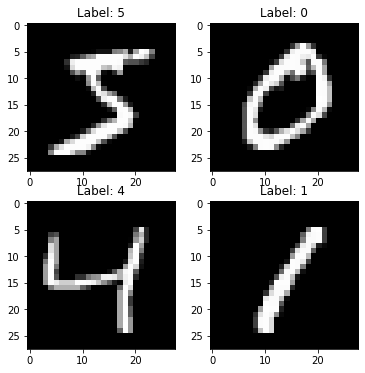

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

## Simple network with 2 layers

Here we'll test the most basic network with 2 hidden layers, ReLU activation function and stochastic gradient descent.


Epoch 24
Train accuracy: 0.99996
Val accuracy: 0.9806


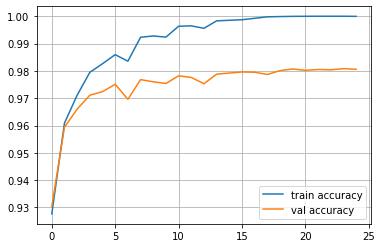

In [15]:
np.random.seed(21)
network1 = Network()
network1.addLayer(Dense(X_train.shape[1],100))
network1.addLayer(ReLU())
network1.addLayer(Dense(100,200))
network1.addLayer(ReLU())
network1.addLayer(Dense(200,10))

training_loop(network1, X_train,y_train,batchsize=32,shuffle=True)

Let's see what happens with the same network when we use momentum gradient descent method.

Epoch 24
Train accuracy: 0.99982
Val accuracy: 0.9797


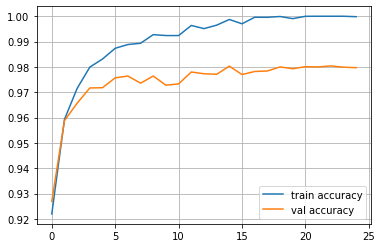

In [16]:
np.random.seed(21)
network2 = Network()
network2.addLayer(DenseMomentum(X_train.shape[1],100))
network2.addLayer(ReLU())
network2.addLayer(DenseMomentum(100,200))
network2.addLayer(ReLU())
network2.addLayer(DenseMomentum(200,10))

training_loop(network2, X_train,y_train,batchsize=32,shuffle=True)

The difference between stochastic gradient descent and momentum gradien descent isn't that big, but we can see that in the second case the accuracy does oscillate less, which one should expect from momentum gradient descent since using the exponential average helps with identifying more straightforward path towards minimum in the loss function space. 

Let's see what happens when we have two deep networks, one that's not using Xavier initialization and one uses Xavier initialization.

Epoch 24
Train accuracy: 0.11356
Val accuracy: 0.1064


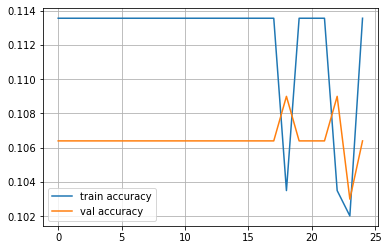

In [17]:
np.random.seed(21)
network3 = Network()
network3.addLayer(Dense(X_train.shape[1],100))
network3.addLayer(ReLU())
network3.addLayer(Dense(100,80))
network3.addLayer(ReLU())
network3.addLayer(Dense(80,40))
network3.addLayer(ReLU())
network3.addLayer(Dense(40,20))
network3.addLayer(ReLU())
network3.addLayer(Dense(20,10))

training_loop(network3, X_train,y_train,batchsize=32,shuffle=True)

Epoch 24
Train accuracy: 0.99902
Val accuracy: 0.979


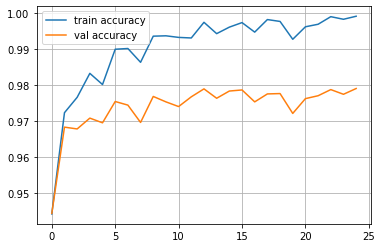

In [27]:
np.random.seed(21)
network4 = Network()
network4.addLayer(Dense(X_train.shape[1],100,True))
network4.addLayer(ReLU())
network4.addLayer(Dense(100,80,True))
network4.addLayer(ReLU())
network4.addLayer(Dense(80,40,True))
network4.addLayer(ReLU())
network4.addLayer(Dense(40,20,True))
network4.addLayer(ReLU())
network4.addLayer(Dense(20,10,True))

training_loop(network4, X_train,y_train,batchsize=32,shuffle=True)

The difference here is strinking, unlike the first case. Just changing from default initialization to Xavier literaly changed this network from useless to 0.979 accuracy. For given default initialization the weights are too small compared to the number of nodes (note that we've used 0.01 sigma). So what actually happens here? The weights are very small, and this in turn means that almost nothing will activate the relu function. So, pretty much any input produces the same results, that is zero, and because of that, it's hard to see where the function needs to go in order to reach the minimum - can't get to a minimum if our loss function is pretty much the same for any input. This is especially obvous when we have relu and small weights since they all become zero. Let's see what happens when we use sigmoid activation layer.



Epoch 24
Train accuracy: 0.11356
Val accuracy: 0.1064


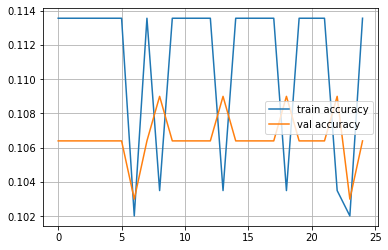

In [29]:
np.random.seed(21)
network5 = Network()
network5.addLayer(Dense(X_train.shape[1],100))
network5.addLayer(Sigmoid())
network5.addLayer(Dense(100,80))
network5.addLayer(Sigmoid())
network5.addLayer(Dense(80,40))
network5.addLayer(Sigmoid())
network5.addLayer(Dense(40,20))
network5.addLayer(Sigmoid())
network5.addLayer(Dense(20,10))

training_loop(network5, X_train,y_train,batchsize=32,shuffle=True)

It's a bit different here, after all, different values map into different values in activation function, so there's a way to "better" differentiate where one should go. We can see that there is a change in accuracy, but again, the weights are too small, so those differences aren't big enough. 

And one might say that I've fixed the weights to make it this bad. But the truth is, as soon as I make a different architecture with significantly different number of nodes, the ones I selected as default will become too small or too big. But with Xavier initialization, I do not need to think about fine tuning them at the begining. 

The idea behind initialization is pretty simple. Make sure that variance is disproportionate to the total number of inputs or inputs and outputs (you'll see both of these definitions, for example [here](https://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)). And it does make perfect sense. 


Finally, let's take the same network and apply everything to it - Xavier initialization, regularization and momentum gradient descent and see what improvements we get.

Epoch 24
Train accuracy: 0.95448
Val accuracy: 0.9545


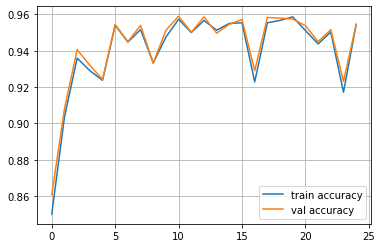

In [35]:
np.random.seed(21)
network6 = Network()
network6.addLayer(Dense(X_train.shape[1],100,True, regularization = 0.01))
network6.addLayer(ReLU())
network6.addLayer(Dense(100,80,True, regularization = 0.01))
network6.addLayer(ReLU())
network6.addLayer(Dense(80,40,True, regularization = 0.01))
network6.addLayer(ReLU())
network6.addLayer(Dense(40,20,True, regularization = 0.01))
network6.addLayer(ReLU())
network6.addLayer(Dense(20,10,True, regularization = 0.01))

training_loop(network6, X_train,y_train,batchsize=32,shuffle=True)

We see that when we apply regularization train and actual accuracy become closer, so we can say that accuracy we get on the test set is more realistic.